In [20]:
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import music21
import matplotlib as plt
import torchvision.utils as vutils
import json
import torch.backends.cudnn as cudnn
torch.cuda.empty_cache()
cudnn.benchmark = True  # Optimise for hardware

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [28]:
BATCH_SIZE = 64
EPOCHS = 100
NOISE_DIM= 100
NUM_CLASSES = 18
EMBEDDING_DIM = 50
MODEL_PATH = "80_20_gen.pt"
LABEL_MAPPING_PATH = "Lable_Mapping.json"
EVAL_SONG_PATH = "Generated_songs/Batch2"

In [22]:


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Embedding for the labels
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBEDDING_DIM)  # (N, 50)

        # Dense layer for the label embedding
        self.fc_label = nn.Linear(EMBEDDING_DIM, 8 * 16)  # (N, 128)

        # Dense layer for the latent noise input
        self.fc_noise = nn.Linear(NOISE_DIM, 128 * 8 * 16)  # (N, 128 * 8 * 16)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1),  # Upsample to 16x32
            nn.BatchNorm2d(128), nn.ReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample to 32x64
            nn.BatchNorm2d(64), nn.ReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Upsample to 64x128
            nn.BatchNorm2d(32), nn.ReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)     # Upsample to 128x256
        )

        #self._initialize_weights()
        
    def forward(self, noise, labels):
       
        # Step 1: Embed the labels
        label_embedding = self.label_emb(labels)  # (N, EMBEDDING_DIM)
        
        label_embedding = self.fc_label(label_embedding)  # (N, 128)
    
        label_embedding = label_embedding.view(BATCH_SIZE, 8, 16, 1)  # Reshape to (N, 8, 16, 1)
        
        # Step 2: Process the latent noise input through a dense layer
        noise_embedding = self.fc_noise(noise)  # (N, 128 * 8 * 16)
        #noise_embedding = torch.relu(noise_embedding)  # Apply ReLU
        noise_embedding = noise_embedding.view(-1, 128, 8, 16)  # Reshape to (N, 128, 8, 16)

        # Step 3: Concatenate the noise and label embeddings along the channel axis
        x = torch.cat((noise_embedding, label_embedding.permute(0, 3, 1, 2)), dim=1)  # (N, 129, 8, 16)

        x = self.model(x)  # Apply the transposed convolutional layers

        # Step 9: Apply sigmoid activation to get output in range [0, 1]
        out = torch.sigmoid(x)  # Sigmoid activation for binary output

        return out  # Return the outp
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.weight.data *= 0.1
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [29]:
netG = Generator().to(device)

# Load the previously saved state of the generator model from the model file
netG.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

<All keys matched successfully>

In [31]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM,  device=device)
labels = []

# Generate 3 samples per label
for i in range(NUM_CLASSES):
    for _ in range(3):
        labels.append(i)

for j in range(10):
    labels.append(j)

labels_as_array = np.array(labels)
label_tensor = torch.tensor(labels_as_array, device=device)
# label = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,), device=device)


outputs = netG(fixed_noise, label_tensor)
print(outputs.shape)

torch.Size([64, 1, 128, 256])


In [32]:
def convert_ints_labels(value):
    """ 
    Function that takes in the integer value from the label dictionary and returns the corresponding label.
    """
    with open(LABEL_MAPPING_PATH, "r") as fp:
        mappings = json.load(fp)

    for key, val in mappings.items():
        if val == value:
            return str(key)



In [33]:
import music21 as m21
import os
OUTPUT_FILES = "training_files"
TIME_STEP = 0.25

def convert_stream(matrix, format="midi", file_name='output.mid',filepath=OUTPUT_FILES, step_duration=TIME_STEP):
    """
    Converts the piano roll matrix back into a music 21 stream. Writes this stream to a midi file.
    :params matrix: 2D piano roll matrix
    :params format: format file type to write the stream
    :params file_name: the file name of the output file
    :params filepath: the output path of the directory holding the output files
    :params step_duration: the size of the step on the x axis of the piano roll matrix
    :returns None.
    """
    
    # Find the shape of the input matrix
    
    rows, cols = matrix.shape
    matrix = (matrix > 0.51).float()
    nulls = np.zeros((rows, 1))
    matrix = np.hstack((matrix, nulls))
    # Create two dictionaries. The first holds the notes that are on. The second holds each 'finished' note and its offset
    active_notes = {}
    note_list = {}

    # Iterates through every member in the matrix
    for col in range(cols - 1):
        for row in range(rows - 1):
            # Finds the midi pitch and creates a new note to represent the pitch and duration
            midi_pitch = row
            note = m21.note.Note(midi_pitch)
            note.quarterLength = step_duration

            # If this note is 'on':
            if matrix[row, col] == 1:
                # remove midi pitches outside the range of a piano
                if midi_pitch < 21 or midi_pitch > 95:
                    continue
                # Checks if the note has already been turned on, or is active.
                if midi_pitch in active_notes:
                    
                    # If already active, updates the step duration of the note in the dictionary
                    lst = active_notes[midi_pitch]
                    lst[0] = lst[0] + step_duration
                    active_notes[midi_pitch] = lst

                # If newly activated, then adds the note duration and offset items to the midi pitch key in the dictionary
                else:
                    note.offset = col * step_duration
                    active_notes[midi_pitch] = [note.quarterLength, note.offset]

            # If the member is off but still in acitve notes, creates a new note and removes it from the dictionary
            elif midi_pitch in active_notes:
                # Grabs the duration and offset of the note and creates a new note object with duraiton, offset, midi pitch attributes
                lst = active_notes[midi_pitch]
                note = m21.note.Note( midi_pitch)
                note.quarterLength = lst[0]
                note.offset = lst[1]
                # Adds this note to the note dictionary based off of the offset
                note_list[note.offset] = note
                del active_notes[midi_pitch]
                    
    # Creates a new stream and grabs the keys (offsets) and values (note onjects) from the note list dictionary
    new_stream = m21.stream.Stream()
    keys = list(note_list.keys())
    notes = list(note_list.values())

    # Iterates through every item in the dictionary
    for i in range(len(note_list)):
        # Inserts the note based off of its offset
        new_stream.insert(keys[i], notes[i])

    # Creates the filepath for the output file
    path = os.path.join(filepath, file_name)

    # Makes the directory if it doesn't exist
    os.makedirs(filepath, exist_ok=True)

    # Writes the stream as a midi file to the path
    new_stream.write(format, fp=path)



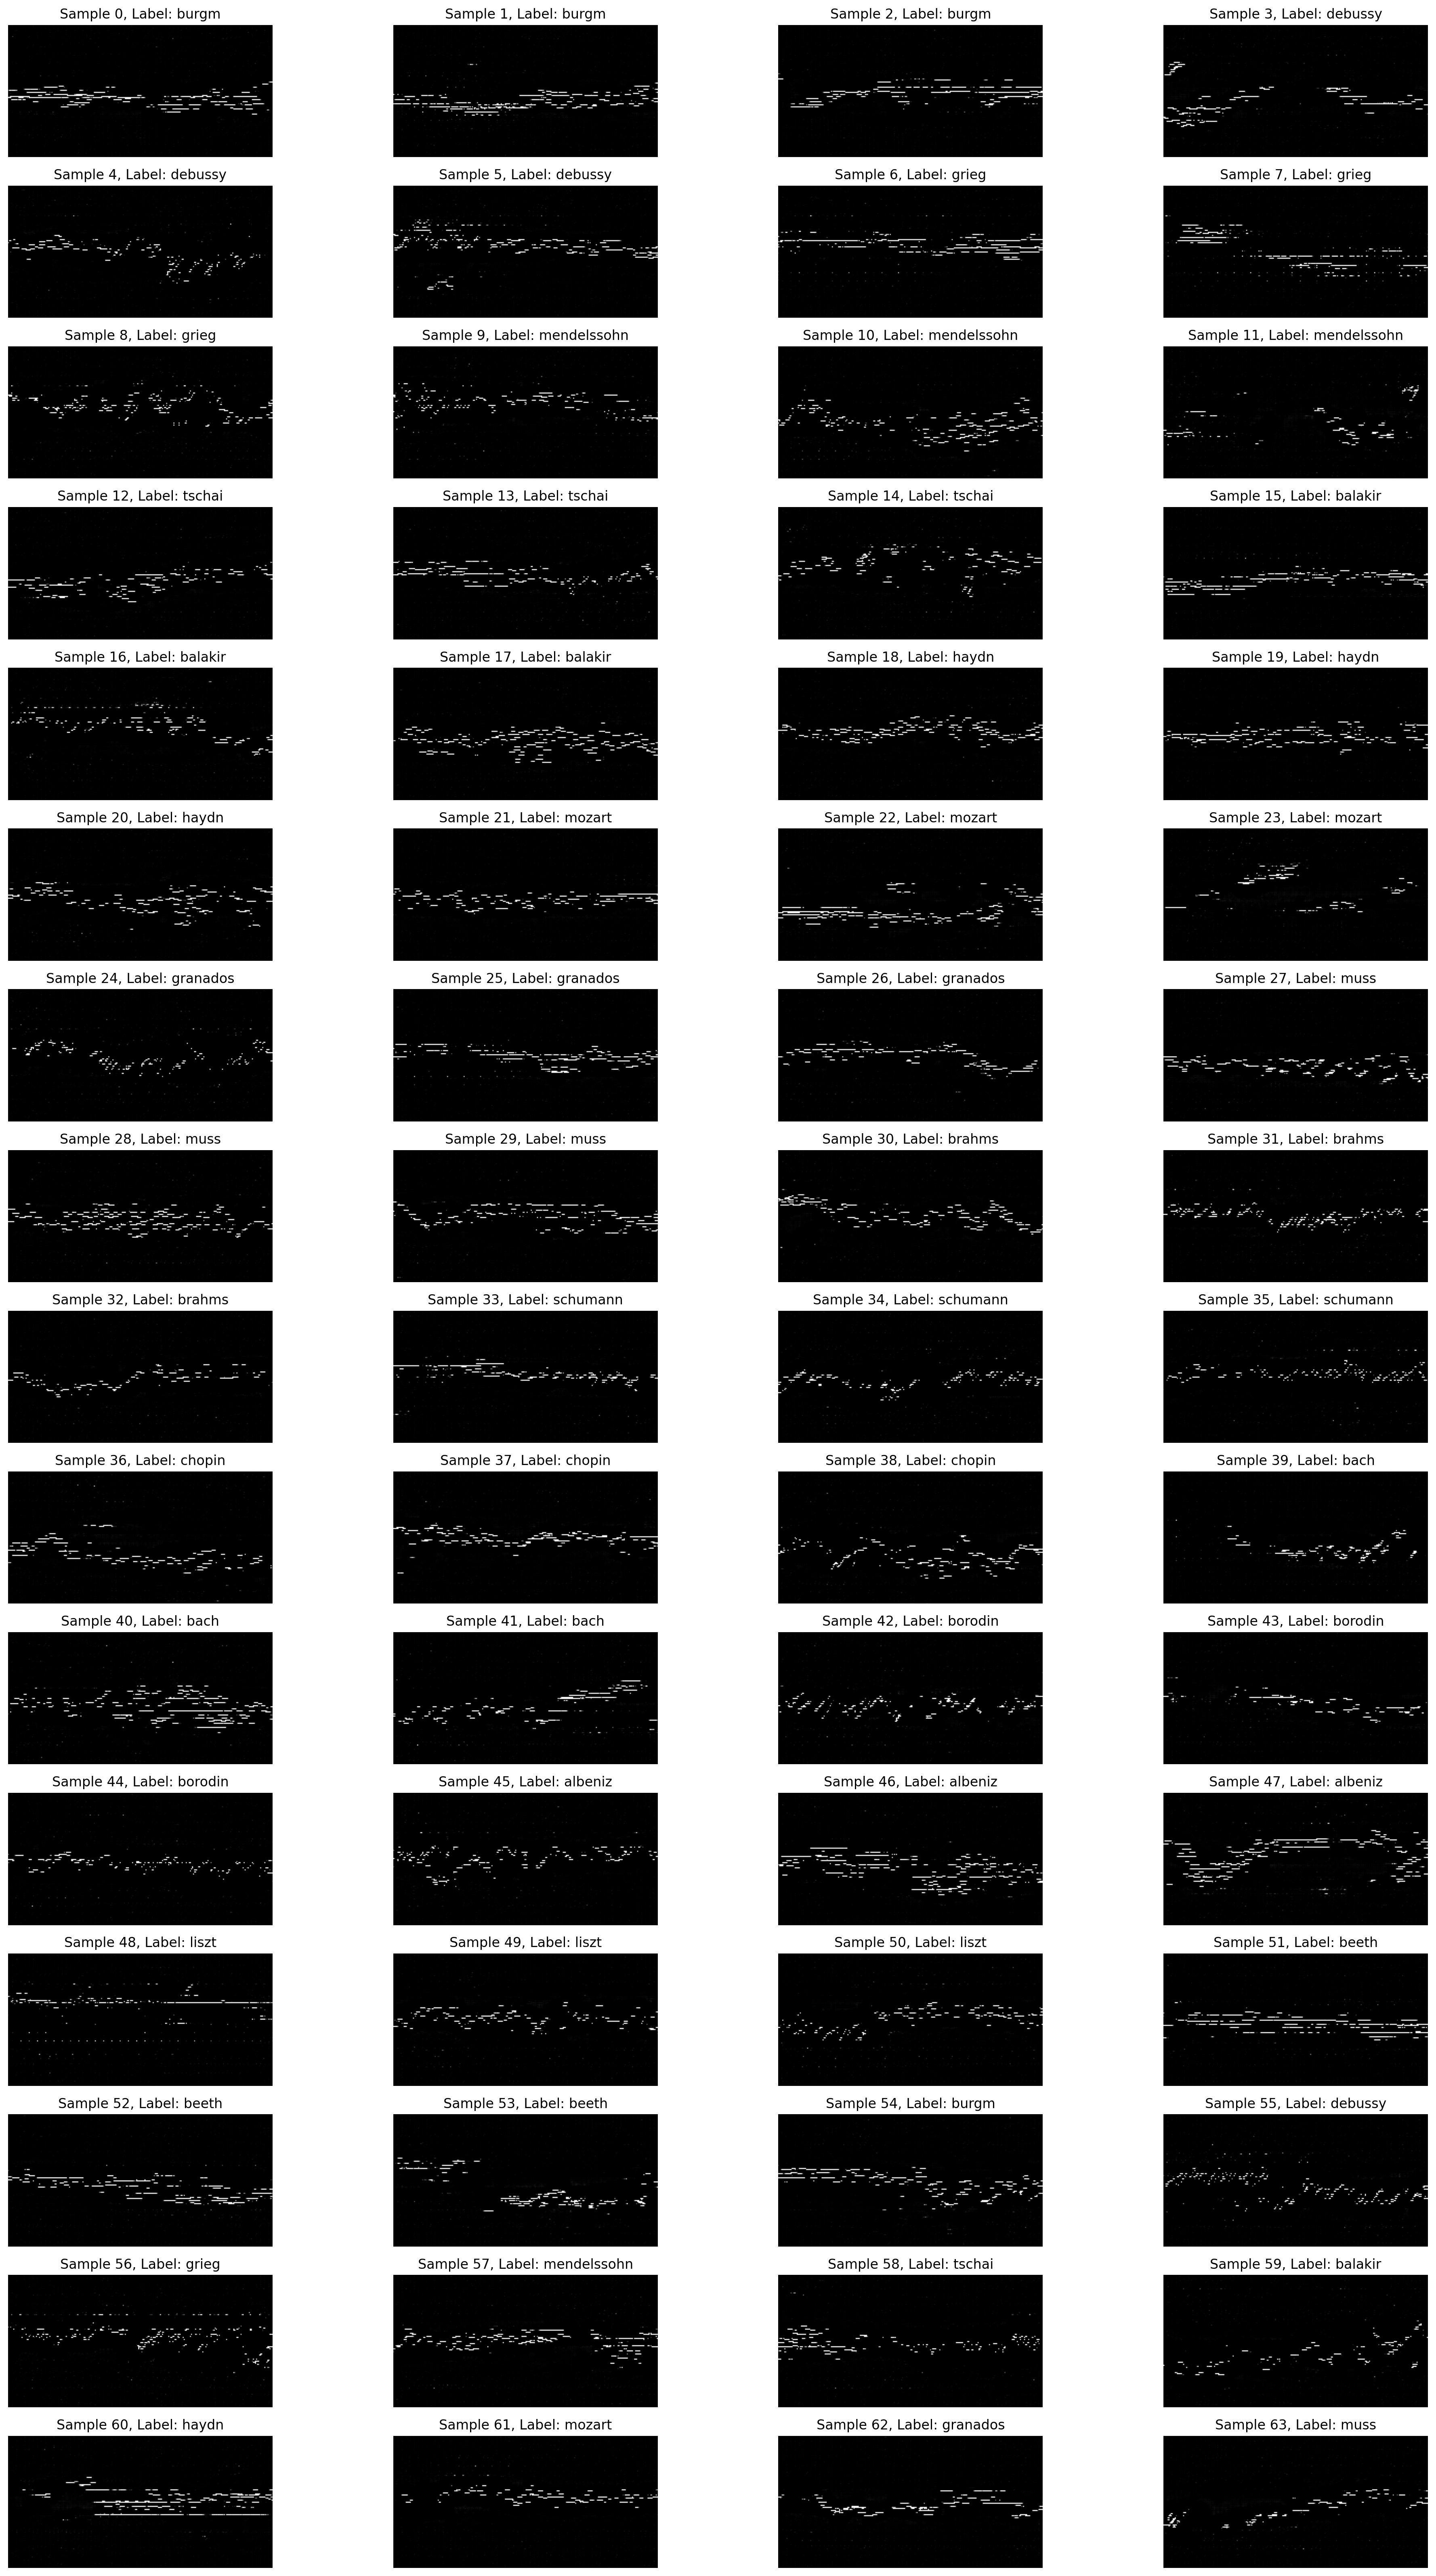

In [34]:
import matplotlib.pyplot as plt

# Set the number of samples to display
num_samples = BATCH_SIZE
samples_per_row = 4
num_rows = num_samples // samples_per_row

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, samples_per_row, figsize=(20, num_rows *2))

# # Loop through the samples
for i in range(BATCH_SIZE):
    
    
    # Visualize the generated sample
    sample = outputs[i][0].cpu()  # Remove batch dimension
    
    lbl_title = convert_ints_labels(label_tensor[i].item())
    file = f"Sample_{i}_{lbl_title}.mid"
    # Determine the current subplot position
    row = i // samples_per_row
    col = i % samples_per_row

    convert_stream(outputs[i][0].cpu(), file_name=file, filepath=EVAL_SONG_PATH)
    # Plot the sample
    axs[row, col].imshow(sample.detach().numpy(), cmap='gray')  # Use cmap='gray' for single-channel images
    axs[row, col].axis('off')  # Turn off axis
    axs[row, col].set_title(f'Sample {i}, Label: {lbl_title}')  # Optional: add a title

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Output_files/80_20_samples.pdf")
# Show the plot
plt.show()